
# Experiments for extracting images of Boyd's Bird Journal into computer readable form

(See image below)

The journals are PDFs containing a series of scanned images of observations of birds. The observations are scanned handwritten notes on graph paper. There are bird species labels running down the left side of the page and date information across the top. The charts are organized by month with days of the month being column headings. There are between 2 and three months of information for each image.

Each cell has a mark indicating the presence or absence of a bird species on a given day. So there is, potentially, one mark per bird species per day. The mark on the page is typically a forward slash "/" but it can also be an "x" or an asterisk "*". We are treating all types of marks the same, a cell either has a mark or it doesn't.

Somethings to note here:
- The graphs are not clean and contain notes and stray marks.
- The scans do not always have nice strong lines to pick out.
- The scans of the graphs are crooked and contain distortions, so the lines are slightly bent, typically near the edges.
- Some of the lines are incomplete or missing. In the image below, May 1986 has more grid cells than June 1986. And the line to the left of May 1st is incomplete.

<img  src="assets/Boyd_M_Bird_journal_section1-024.png"/>

In [1]:
%load_ext watermark
%watermark -a 'Raphael LaFrance' -i -u -v -r -g -p numpy,matplotlib,skimage

Raphael LaFrance 
last updated: 2017-10-27T00:12:31-04:00

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
matplotlib 2.1.0
skimage 0.13.1
Git hash: f6452568b5968a06efb9365fe4e388d6a455bf6e
Git repo: https://github.com/rafelafrance/boyd-bird-journal.git


## Extract images from PDF files

First we need to extract individual images from the PDFs. This is easily accomplished in Linux with the command `pdfimages`. This is part of either the poppler or xpdf packages. We're using `bash` to make a directory to hold the images and then extracting the PDF images into that directory. The first 20 images are not relevant here.

In [2]:
%%bash

RAW_DATA='raw_data'
DIRECTORY='images'

PDF1="$RAW_DATA/Boyd_M_Bird_journal_section1.pdf"
PDF2="$RAW_DATA/Boyd_M_Bird_journal_section2.pdf"

PREFIX1="$DIRECTORY/Boyd_M_Bird_journal_section1"
PREFIX2="$DIRECTORY/Boyd_M_Bird_journal_section2"

if [ ! -d "$DIRECTORY" ]; then
    mkdir $DIRECTORY
    pdfimages -png $PDF1 $PREFIX1
    pdfimages -png $PDF2 $PREFIX2
fi

## Setup

We are using a fairly standard scipy stack: `numpy` & `matplotlib`. The only addition is the use of `scikit-image`.

In [3]:
%matplotlib notebook
# %matplotlib inline

import os
import csv
from itertools import product
from collections import namedtuple

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches, cm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# import cv2

from skimage import io
from skimage import util
# from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line, rotate

from lib.util import Crop
from lib.cell import Cell
from lib.grid import Grid
from boyd_journal_extraction import split_image, get_month_graph_areas, build_month_graphs
from boyd_journal_extraction import init_csv_file, output_results, process_image

In [4]:
# in_file = 'images/Boyd_M_Bird_journal_section1-024.png'
in_file = 'images/Boyd_M_Bird_journal_section1-063.png'

CSV_PATH = 'output/boyd_bird_journal.csv'

## Brief description of the Hough transform

We're using the Hough Transform to find lines in the image. It's an efficient and old algorithm for finding objects in an image. Efficient because it only scans the image once.

The basic idea of the algorithm is:

1. Set up a table of every possible line in the image. The lines are in polar form (rho, theta).
    1. Lines are limited to a given set of angles.
    1. This table will hold a count of all of the "on" pixels for the line.
1. Scan the image for "on" pixels.
1. When a pixel is "on", add one to every possible line that goes thru the pixel it.
1. After every pixel has been recorded choose all lines with a count that is greater than a given threshold.

See the [Wikipedia Page](https://en.wikipedia.org/wiki/Hough_transform) for a more detailed description.

## Split the image into left-hand and right-hand sides

In [5]:
full_image = Grid(file_name=in_file)

In [6]:
left_side, right_side = split_image(full_image)

print(full_image.shape)
print(left_side.shape)
print(right_side.shape)

(5100, 3300)
(5100, 1450)
(5100, 1850)


In [7]:
full_image.horiz.threshold = full_image.horiz.size * 0.2
full_image.horiz.find_grid_lines()

<IPython.core.display.Javascript object>


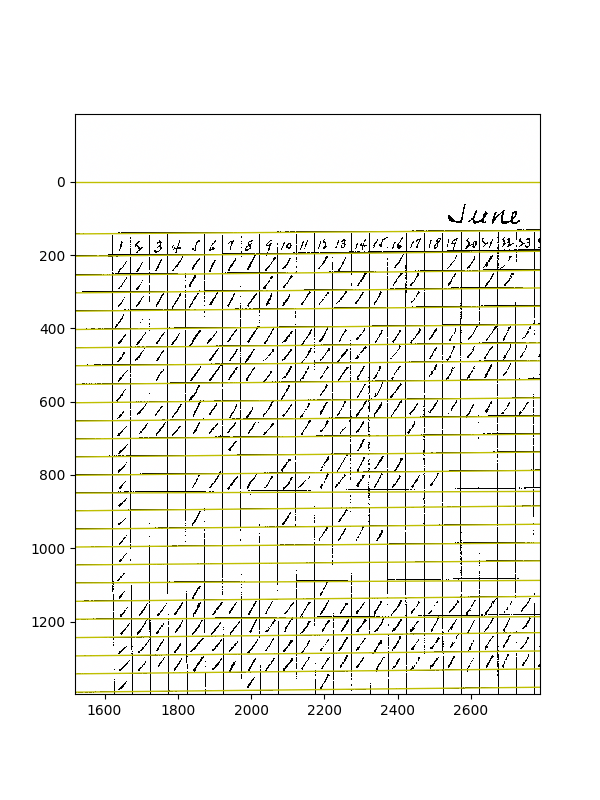

In [8]:
fig, ax = plt.subplots(figsize=(6, 8))
ax.imshow(full_image.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in full_image.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

In [ ]:
full_image.get_rows()

## Get the horizontal and vertical grid lines

As described above, we need to define a line as a threshold on the line count. However, there is a wrinkle, the images are not square with the width being the shorter dimension (3300px width x 5100px height). To accommodate this we will make two passes over the image. One for the horizontal lines and one for the vertical line.

In [9]:
left_side.horiz.find_grid_lines()
left_side.vert.find_grid_lines()

#### Add a vertical grid line after the first one.

We're expecting two columns of cells on the left side of the image. The cells are rather long and typically have lots of whitespace toward the right end. We expect the 1st cell to have a row number and the 2nd cell to have the bird's species identification. We are going to look at the 2nd cell to see if there is any writing in it. To help boost the signal we are going to chop the 2nd cell at a fixed width and look at that part for writing.

In [10]:
left_side.vert.insert_line(from_this_line=left_side.vert.lines[1],
                           distance=-50)

#### Look at the grid from the left side of the image

<IPython.core.display.Javascript object>


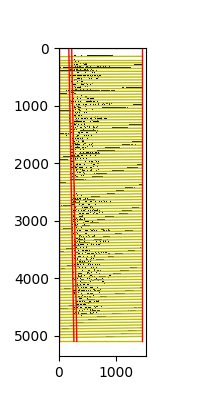

In [11]:
fig, ax = plt.subplots(figsize=(2, 4))
ax.imshow(left_side.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

## Get grid cells in the left side of the image

In [12]:
left_side.get_cells()
left_side.get_row_labels()

print(len(left_side.cells))
print(len(left_side.cells[0]))

100
3


## Look for writing in the second cell of each row

In [13]:
left_side.get_row_labels()

In [14]:
@interact(row=(0, len(left_side.cells) - 1), col=(0, len(left_side.cells[0]) - 1))
def draw_row_label_interior(row, col):
    print('has label' if left_side.row_labels[row] else 'no label')
    fig, ax = plt.subplots(figsize=(6, 2))
    ax.imshow(left_side.cells[row][col].interior(crop=Cell.crop), cmap=plt.cm.gray)

# draw_row_label_interior(24, 1)

interactive(children=(IntSlider(value=49, description='row', max=99), IntSlider(value=1, description='col', max=2), Output()), _dom_classes=('widget-interact',))

### Now split the right side into separate graphs

In [15]:
months = get_month_graph_areas(left_side, right_side)

for month in months:
    print(month.shape)

(2200, 1850)
(2233, 1850)


In [16]:
build_month_graphs(months)

for m, month in enumerate(months):
    print('month: {} rows: {}  cols: {}'.format(
        m, len(month.cells), len(month.cells[0])))

month: 0 rows: 43  cols: 33
month: 1 rows: 44  cols: 33


#### Look the resulting grid

In [17]:
@interact(mon=(0, len(months) - 1))
def show_month_grid(mon):
    month = months[mon]
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(month.image, cmap=plt.cm.gray)
    ax.set_title('Grid {}'.format(mon))

    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    plt.tight_layout()
    plt.show()

# show_month_grid(0)

interactive(children=(IntSlider(value=0, description='mon', max=1), Output()), _dom_classes=('widget-interact',))

### Find column labels

In [18]:
@interact(mon=(0, len(months) - 1), col=(0, 35))
def draw_column_header_interior(mon, col):
    month = months[mon]
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[0][col]
    interior = cell.interior(crop=Cell.crop)

    mean = np.mean(interior)
    print('mean', mean)
    print('yes' if cell.is_label() else '')

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = cell.has_line()
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

# draw_column_header_interior(1, 2)

interactive(children=(IntSlider(value=0, description='mon', max=1), IntSlider(value=17, description='col', max=35), Output()), _dom_classes=('widget-interact',))

### Look for forward slashes in grid cells

In [19]:
forward_slashes = np.linspace(65.0, 25.0, num=161)
print(forward_slashes)
forward_slashes = np.deg2rad(forward_slashes)

[ 65.    64.75  64.5   64.25  64.    63.75  63.5   63.25  63.    62.75
  62.5   62.25  62.    61.75  61.5   61.25  61.    60.75  60.5   60.25  60.
  59.75  59.5   59.25  59.    58.75  58.5   58.25  58.    57.75  57.5
  57.25  57.    56.75  56.5   56.25  56.    55.75  55.5   55.25  55.    54.75
  54.5   54.25  54.    53.75  53.5   53.25  53.    52.75  52.5   52.25  52.
  51.75  51.5   51.25  51.    50.75  50.5   50.25  50.    49.75  49.5
  49.25  49.    48.75  48.5   48.25  48.    47.75  47.5   47.25  47.    46.75
  46.5   46.25  46.    45.75  45.5   45.25  45.    44.75  44.5   44.25  44.
  43.75  43.5   43.25  43.    42.75  42.5   42.25  42.    41.75  41.5
  41.25  41.    40.75  40.5   40.25  40.    39.75  39.5   39.25  39.    38.75
  38.5   38.25  38.    37.75  37.5   37.25  37.    36.75  36.5   36.25  36.
  35.75  35.5   35.25  35.    34.75  34.5   34.25  34.    33.75  33.5
  33.25  33.    32.75  32.5   32.25  32.    31.75  31.5   31.25  31.    30.75
  30.5   30.25  30.    29.75  29.

In [20]:
@interact(mon=(0, len(months) - 1), row=(1, 40), col=(0, 35))
def draw_cell_interior(mon, row, col):
    month = months[mon]
    row = -1 if row >= len(month.cells) else row
    col = -1 if col >= len(month.cells[0]) else col

    cell = month.cells[row][col]
    interior = cell.interior(Cell.crop)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(interior, cmap=plt.cm.gray)

    lines = probabilistic_hough_line(
        interior, line_length=15, theta=forward_slashes)
    for ((x0, y0), (x1, y1)) in lines:
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

    print('lines', len(lines))
    print('yes' if len(lines) else '')


# draw_cell_interior(1, 18, 31)
# draw_cell_interior(1, 27, 27)

interactive(children=(IntSlider(value=0, description='mon', max=1), IntSlider(value=20, description='row', max=40, min=1), IntSlider(value=17, description='col', max=35), Output()), _dom_classes=('widget-interact',))

In [21]:
@interact(mon=(0, len(months) - 1))
def show_slashes(mon):
    month = months[mon]
    for row in month.cells[1:-1]:
        for col, cell in enumerate(row):
            if month.col_labels[col]:
                print('/' if cell.has_line(forward_slashes) else '.', end=' ')
        print()
# show_slashes(0)

interactive(children=(IntSlider(value=0, description='mon', max=1), Output()), _dom_classes=('widget-interact',))

### Stitch image parts back together to report output

This image shows how we broke up the input image to get the monthly charts. Doing it this way reduces distortion.

<IPython.core.display.Javascript object>


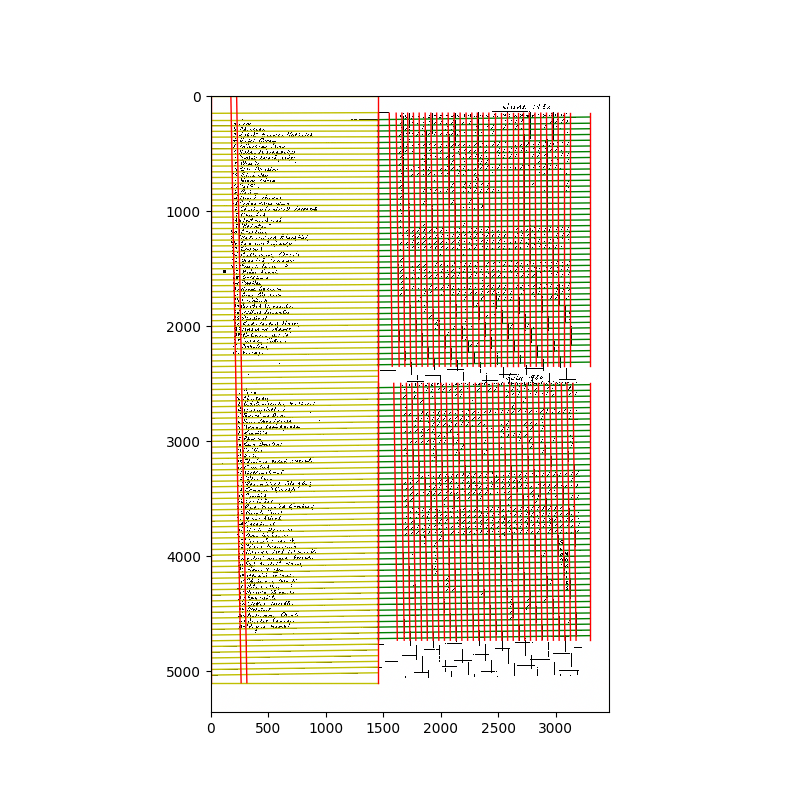

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(full_image.image, cmap=plt.cm.gray)

for ((x0, y0), (x1, y1)) in left_side.horiz.lines:
    ax.plot((x0, x1), (y0, y1), '-y', linewidth=1)

for ((x0, y0), (x1, y1)) in left_side.vert.lines:
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

for month in months:
    for ((x0, y0), (x1, y1)) in month.horiz.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-g', linewidth=1)

    for ((x0, y0), (x1, y1)) in month.vert.lines:
        x0 += month.offset.x
        x1 += month.offset.x
        y0 += month.offset.y
        y1 += month.offset.y
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)

plt.show()

## Output the results

<IPython.core.display.Javascript object>


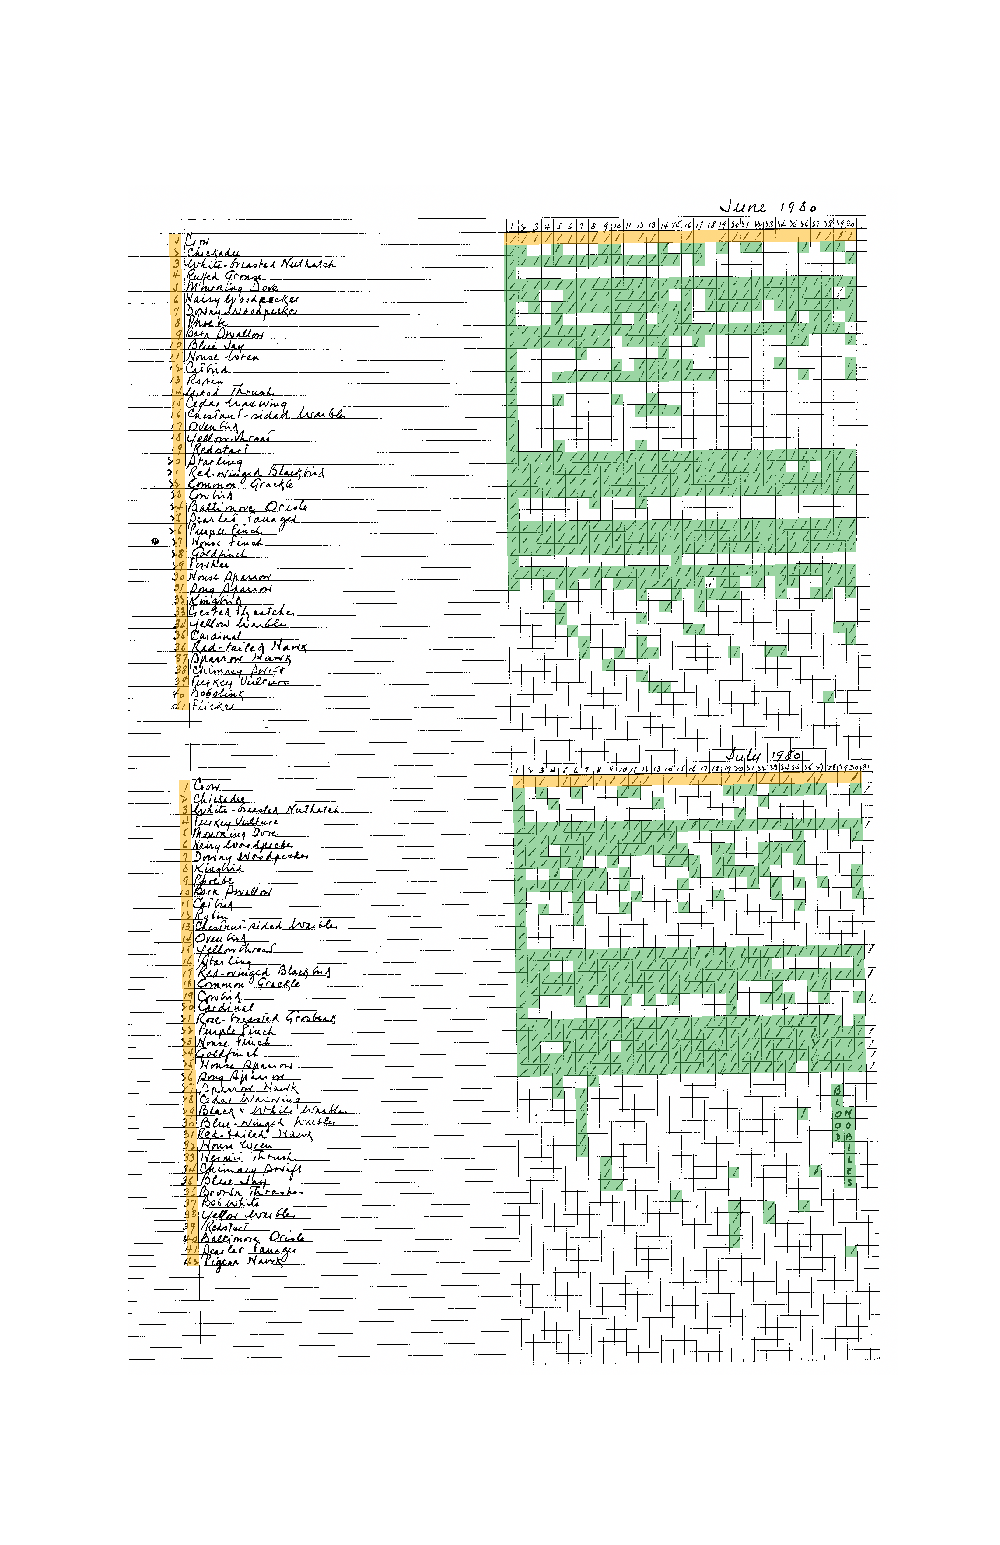

In [23]:
plt = output_results(in_file, CSV_PATH, full_image, left_side, months)
plt.show()

# Failed experiments

- Try merging endpoints: Lines are pretty skew across the entire image. I tried to use interior points to make grid lines. This didn't really help things.

- Probabilistic Hough line: This may work for other parts of the image, like slashes, but it didn't help with either grid lines or row labels. It proved to be much slower and harder to tune for finding grid lines that span the entire image.

- OpenCV: This works, it's just less flexible for searching on a limited set of angles. The ability to pull out the horizontal, vertical, and diagonal lines separately is useful in this application. Also, OpenCV is difficult to install.